In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

In [40]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
                ]
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [87]:
def decision_tree(sj_test, iq_test):
    
    #preprocess data
    sjX_train, iqX_train = preprocess_data('dengue_features_train.csv',
                                           labels_path="dengue_labels_train.csv")
    sjY_train = sjX_train['total_cases']
    iqY_train = iqX_train['total_cases']
    del sjX_train['total_cases'], iqX_train['total_cases']
    
    #define model
    model = DecisionTreeRegressor(max_depth=4)
    
    #predict sj
    model.fit(sjX_train, sjY_train)
    sj_predictions = model.predict(sj_test)    

    #predict iq
    model.fit(iqX_train, iqY_train)
    iq_predictions = model.predict(iq_test)
    
    return np.rint(sj_predictions).astype(int), np.rint(iq_predictions).astype(int)  

In [93]:
def decision_tree_plot():
    
    #preprocess data
    sj_train, iq_train = preprocess_data('dengue_features_train.csv',labels_path="dengue_labels_train.csv")
    msk = np.random.rand(len(sj_train)) < ((2/3))
    X_train = sj_train[msk]
    X_test = sj_train[~msk]
    
    #log transformations
    Y_train = np.log(X_train['total_cases'].as_matrix())
    Y_test = np.log(X_test['total_cases'].as_matrix())
    X_train = np.log(X_train.as_matrix())
    X_test = np.log(X_test.as_matrix())
    
    #predict from model
    model = DecisionTreeRegressor(max_depth=4)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_train)
    predictions = np.rint(predictions).astype(int)
    
    #plotting values
    plt.figure()
    plt.scatter(X_test[:,0], Y_test, c="k", label="testing samples")
    plt.plot(X_train[:,0], predictions, c="g", label="predictions", linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Boosted Decision Tree Regression")
    plt.legend()
    plt.show()

/Users/ThomasHuang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/ThomasHuang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


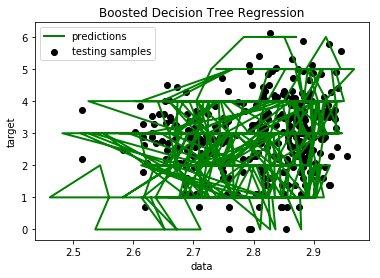

In [94]:
def main():
    sj_test, iq_test = preprocess_data('dengue_features_test.csv')
    sj_predictions, iq_predictions = decision_tree(sj_test, iq_test)
    submission = pd.read_csv('submission_format.csv', index_col=[0, 1, 2])
    submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
    submission.to_csv('decisiontree.csv')
    decision_tree_plot()
main()